In [34]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time 
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, make_scorer
from sklearn import svm, datasets
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from gensim.models import Word2Vec, keyedvectors
from gensim import utils

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
df_original = pd.read_csv('/content/gdrive/My Drive/DataSet/tweet_emotions.csv', encoding='windows-1252')

In [4]:
df = df_original.copy()

In [5]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [6]:
df.count()

tweet_id     40000
sentiment    40000
content      40000
dtype: int64

In [7]:
df.head(5)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [8]:
df = df.loc[:,['sentiment','content']]

In [9]:
df.head(2)

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...


In [12]:
df['sentiment'] = df['sentiment'].str.lower()

In [13]:
df.isnull().sum()

sentiment    0
content      0
dtype: int64

In [14]:
df.shape

(40000, 2)

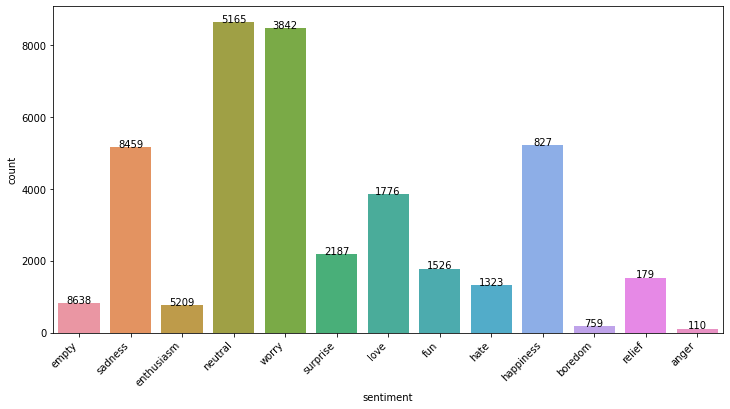

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax = sns.countplot(x='sentiment', data=df)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, height + 0.1, df['sentiment'].value_counts()[i], ha='center')
    i+=1

In [16]:
#removing class if any has a value 1
df = df.groupby('sentiment').filter(lambda x : len(x)>1)

#removing stopwords
stop = stopwords.words('english')
df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#removing urls
df['content'] = df['content'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

#removing HTML Tags
def remove_tags(string):
    result = re.sub('<.*?>', '', string)
    return result
df['content'] = df['content'].apply(lambda cw : remove_tags(cw))

#removing '\n' in the code
df['content'] = df['content'].replace('\n', ' ', regex=True)

#removing punctuations
punctuation = '''!()-[]{};:'"\,<>/?@#$%^&*~'''
def remove_punctuations(text):
    for punc in punctuation:
        text = text.replace(punc, '')
    return text
df['content'] = df['content'].apply(remove_punctuations)

#removing digits
df['content'] = df['content'].str.replace('\d+', '')

In [17]:
df.head(5)

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,Layin n bed headache ughhhh...waitin call...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants hang friends SOON
4,neutral,dannycastillo We want trade someone Houston ti...


In [18]:
#lemmitization
# from nltk.stem import WordNetLemmatizer
# from nltk import word_tokenize

WNlemma = nltk.WordNetLemmatizer()


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def pre_process_with_pos_tag(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if len(t)>2]
    tokens = [WNlemma.lemmatize(t, get_wordnet_pos(pos_tag(word_tokenize(t))[0][1])) for t in tokens]
    text_after_process = " ".join(tokens)
    return text_after_process

In [19]:
df['content'] = df['content'].apply(pre_process_with_pos_tag)

In [20]:
df.head(5)

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin bed headache ughhhh ... waitin call ...
2,sadness,funeral ceremony ... gloomy friday ...
3,enthusiasm,want hang friend soon
4,neutral,dannycastillo want trade someone houston ticke...


In [21]:
#Analysing the words in the content column
results = set()
df['content'].str.lower().str.split().apply(results.update)
print(results)

{'bing', 'spinelli', 'akissforjersey', 'gdask', 'zo_e', 'ammoxxx', 'nungguin', 'bahh', 'styoopid', 'shoo', 'httpblip.fmzy', 'prezzie', 'teeshirt', 'salute', 'natburleson', 'stocksleftampright', 'tiffanylue', 'pokinatcha', 'confsuing', 'datingdad', 'httpbit.lyykksu', 'didddd', 'mattmarquess', 'willadam', 'team', 'talkingwithtami', 'unparalleled', 'loooong..', 'mtfbwy..', 'nesbitt', 'hehehehehe', 'codequot', 'runthrough', 'me..help', 'dying.hafta', 'atkailash', 'owe', 'pindah', 'steamydarcy', 'alisonmyra', 'ekalavyab', 'aaauuuggghhh', 'httpjynxedpanda.com', 'httptwitpic.comhw', 'ac_', 'immigrate', 'giannicash', 'scifileague', 'hangf', 'wither', 'baddestnla', 'uselaine', 'area', 'onchmovement', 'levy', 'twitterfriends', 'barbsaka', 'linkin', 'dreaming_awake', 'crane', 'aprilcandy', 'cutteee', 'peekaboo', 'flyingnutcase', 'roar', 'murakami', 'ajdaddy', 'subscribed', 'hapee', 'feeeeeet', 'moldy', 'betch', 'techstartups', 'antcam', 'heidihabibi', 'nicely', 'nuuuuu', 'yaelzraw', 'tayo', 'exte

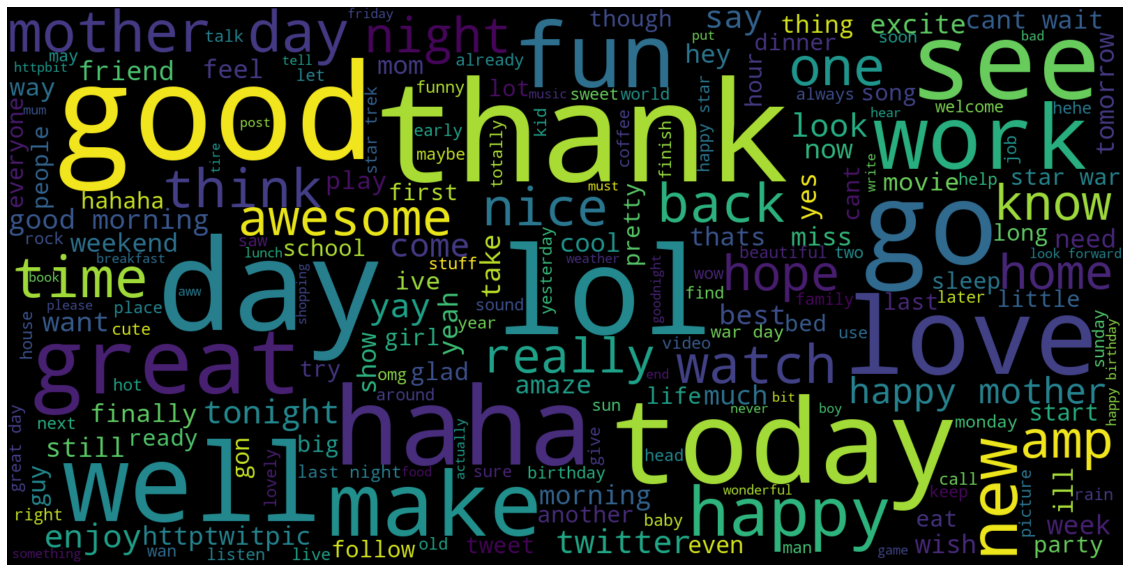

In [22]:
#wordcloud
class_label_0 = df[df['sentiment'] =='happiness']
string_0 = []
for t in class_label_0.content:
    string_0.append(t)
string_0 = pd.Series(string_0).str.cat(sep=' ')
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(string_0)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
class Corpus:
  def __iter__(self):
    for line in df['content']:
      yield utils.simple_preprocess(line)

In [35]:
sentenses = Corpus()
model = Word2Vec(sentences=sentenses, sg=1, size =100, workers=4)

In [37]:
word_vectors = model.wv
model.wv.save_word2vec_format("/content/gdrive/My Drive/DataSet/custom_embedding_100d.txt")

In [38]:
model.wv.vector_size

100

In [39]:
model.wv.get_vector('order')

array([ 5.28068952e-02, -1.38772860e-01,  9.00538787e-02, -1.34211713e-02,
       -5.01823239e-02, -8.99142176e-02, -2.80766577e-01,  2.31209473e-04,
        2.92352229e-01,  2.72414833e-01,  6.35903776e-02, -1.36212274e-01,
        8.13548192e-02, -1.65647343e-02, -1.37326017e-01, -1.03401504e-01,
       -1.26037106e-01, -2.17185602e-01,  5.87391034e-02, -3.04768141e-02,
        1.71344671e-02,  6.15896545e-02, -1.78602338e-01,  1.44577220e-01,
       -2.35529691e-02, -9.04077441e-02,  1.74171060e-01,  7.07504302e-02,
       -5.50253205e-02, -4.61191667e-04, -5.38126603e-02, -3.04691494e-01,
       -1.44210845e-01, -2.29512528e-01, -3.01754296e-01,  1.10990651e-01,
       -8.91974047e-02,  6.56757727e-02, -8.48484039e-02,  7.04768226e-02,
       -1.36565968e-01, -2.64669638e-02, -1.02827623e-01,  2.28994098e-02,
        1.29784420e-01,  9.07877609e-02,  1.77354336e-01, -1.15684457e-02,
       -1.36041502e-02, -5.61972633e-02, -1.01207942e-01,  2.75408149e-01,
        1.35279506e-01, -

In [40]:
model.wv.most_similar('order')

[('log', 0.9731841087341309),
 ('battery', 0.9703466892242432),
 ('onto', 0.9699212312698364),
 ('brand', 0.9696618318557739),
 ('client', 0.9686247110366821),
 ('blackberry', 0.9685255289077759),
 ('mobile', 0.9684507846832275),
 ('server', 0.9682706594467163),
 ('instal', 0.9669209122657776),
 ('laptop', 0.9668488502502441)]